## Notebook to analyze CCGP populations from Erik Enbody

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
import scipy as sp
from joblib import Parallel, delayed
from random import choices
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import haversine_distances

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import plotly.express as px

# wolves_graph
import os
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats, run_cv_joint
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range, get_best_lre
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [147]:
# set file & species id up here
os.chdir("/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/")
filename = "41-Passerculus"

In [148]:
coord = np.loadtxt("{}/{}.coords.txt".format(filename,filename),usecols=(1,2))  # sample coordinates
outer = np.loadtxt("59-Ursus_Example/california_grid.txt")  # outer coordinates
grid_path = "59-Ursus_Example/world_triangle_res8.shp"  # path to discrete global grid

(bim, fam, G) = read_plink("{}/{}".format(filename,filename))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=1,
                                             outer=outer)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 34.77it/s]


n_samples=151, n_snps=100225


/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [149]:
sp_graph = SpatialGraph(genotypes, coord, grid, edges)

# lamb_grid = np.geomspace(1e-2, 1e2, 10)[::-1]
# cv_err = run_cv(sp_graph, lamb_grid, n_folds=10, factr=1e10)
# mean_cv_err = np.mean(cv_err, axis=0)
# plt.plot(lamb_grid, mean_cv_err, '-ko'); plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.axvline(lamb_grid[np.argmin(mean_cv_err)],color='orange'); plt.semilogx()

In [150]:
# lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
# sp_graph.fit(lamb=lamb_cv, optimize_q=None, lamb_q=1.)
sp_graph.fit(lamb=0.1)
obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.Lpinv = np.linalg.pinv(sp_graph.L.todense()); obj.grad(reg=False)

constant-w/variance fit, converged in 121 iterations, train_loss=3832747.6784033
lambda=0.10000, alpha=0.60048, beta=0.00000, converged in 1412 iterations, train_loss=3515471.65981


Text(0, 0.5, 'genetic distance')

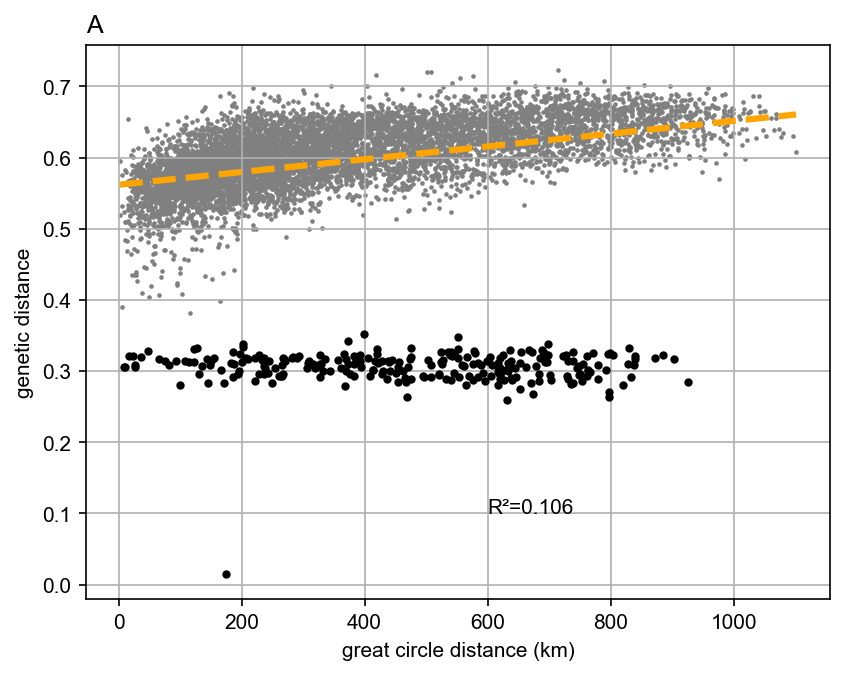

In [117]:
fig = plt.figure(dpi=150)
# D_geno = squareform(pdist(genotypes, metric="sqeuclidean")) / genotypes.shape[1]
# coord_rad = coord[:,::-1] * np.pi / 180.0
# D_geo = haversine_distances(coord_rad) * 6371000/1000
# tril_idx = np.tril_indices(genotypes.shape[0], k=-1)
# x = D_geo[tril_idx]
# y = D_geno[tril_idx]
# X = sm.add_constant(x)
# mod = sm.OLS(y, X)
# res = mod.fit()
# muhat, betahat = res.params

ax_00 = fig.add_subplot(1,1,1)
ax_00.set_title("A", loc='left')
ax_00.scatter(x, 
              y, 
              marker=".", 
              alpha=1, 
              zorder=0, 
              color="grey",
              s=6)
ax_00.plot(x[np.where(res.resid<-0.2)[0]],y[np.where(res.resid<-0.2)[0]],'k.')
x_ = np.linspace(np.min(x), np.max(x), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="orange", linestyle='--', linewidth=3); ax_00.grid();
ax_00.text(600, .1, "R²={:.3f}".format(res.rsquared))
ax_00.set_xlabel("great circle distance (km)")
ax_00.set_ylabel("genetic distance")

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

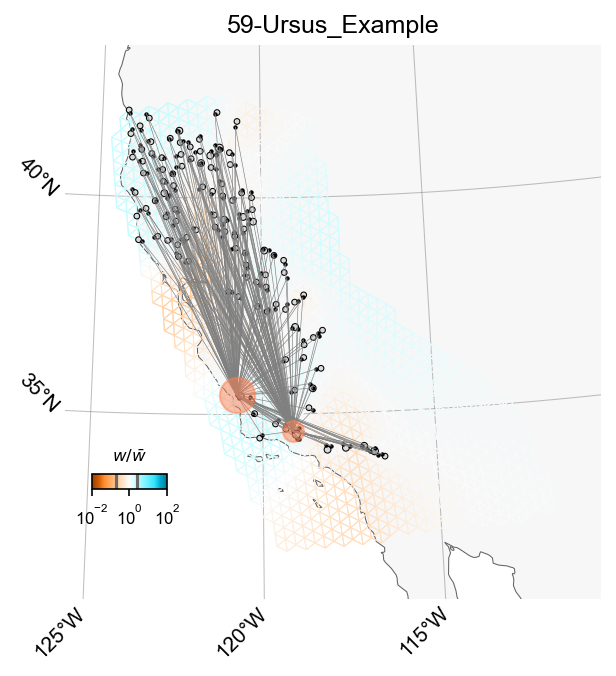

In [134]:
# from feems.viz import project_coords
# max_res_node = []
# for k in np.where(res.resid<-0.2)[0]:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
#     y = int(k - 0.5*x*(x-1))
#     max_res_node.append(np.sort([x,y]).tolist())
    
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=[[35,40],[-115,-120,-125]]); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
v.ax.set_title("{}".format(filename)); v.draw_samples()

for k in max_res_node:
    projxy = project_coords(np.array([coord[k[0],:],coord[k[1],:]]),v.proj)
    v.ax.plot([projxy[0,0],projxy[1,0]],[projxy[0,1],projxy[1,1]],linewidth=0.3,color='grey')

maxidx = np.unique(np.array(max_res_node)[:,1])
projxy = project_coords(coord[np.unique(np.array(max_res_node)[:,1]),:],v.proj)
for ik, k in enumerate(projxy):
    if (ik==0) or (ik==39):
        v.ax.plot(k[0],k[1],'o',color='coral',markersize=10*np.log10(np.sum(np.array(max_res_node)[:,1]==maxidx[ik])+0.1),alpha=0.5)

In [153]:
# projection = ccrs.EquidistantConic(central_longitude=coord[:,0].mean(), central_latitude=coord[:,1].mean())
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(latlong=[[35,40],[-115,-120,-125]]); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.ax.set_title("{}".format(filename))

# tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[tril_idx]
# emp_dist = cov_to_dist(emp_cov)[tril_idx]

# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.8, markersize=4); plt.xlabel('Expected (fit) genetic distance'); 
# plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1); plt.grid()
# plt.text(3.5, 1.5, r'$R^2 \approx {:.2f}$'.format(res.rsquared_adj), fontsize=15); plt.ylabel('Observed genetic distance')

outliers_df = obj.extract_outliers(0.2,verbose=False)

Using a FDR of 0.2:

20 outlier deme pairs found
 source  dest. source (lat., long.) dest. (lat., long.)         pval
    973    982    (41.004, -123.41)  (40.821, -123.692) 1.841765e-11
    795    770    (42.17, -122.009)  (41.994, -122.299) 2.934570e-06
    902    795    (40.45, -124.252)   (42.17, -122.009) 2.866206e-05
    921    795   (40.637, -123.973)   (42.17, -122.009) 5.279641e-05
    720    795    (42.17, -122.009)  (41.637, -122.876) 6.216607e-05
    982    795    (41.004, -123.41)   (42.17, -122.009) 9.575284e-05

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
770    9
795    9
902    1
982    1
Name: dest., dtype: int64


/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

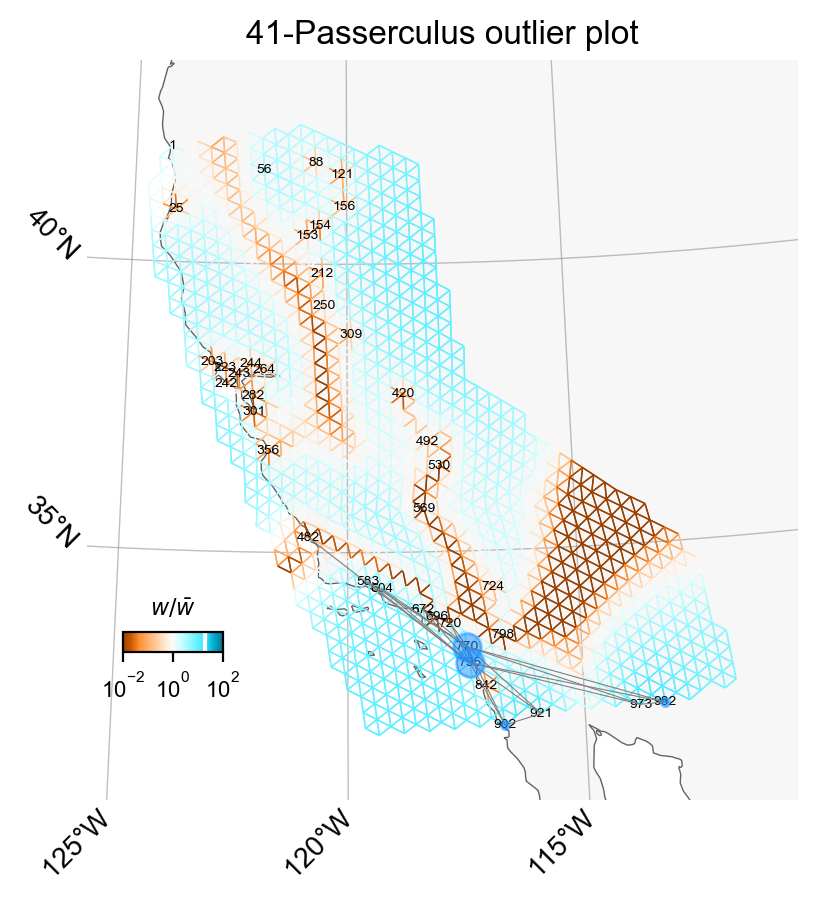

In [154]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=[[35,40],[-115,-120,-125]]); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=True); v.draw_edge_colorbar()
v.ax.set_title("{} outlier plot".format(filename))
for i in range(outliers_df.shape[0]):
    v.ax.plot([v.grid[outliers_df['source'].iloc[i],0],v.grid[outliers_df['dest.'].iloc[i],0]],[v.grid[outliers_df['source'].iloc[i],1],v.grid[outliers_df['dest.'].iloc[i],1]],linewidth=0.4,color='grey')
for dest in np.unique(outliers_df['dest.']):
    v.ax.plot(v.grid[dest, 0], v.grid[dest, 1], 'o', color='dodgerblue', markersize=10*np.log10(np.sum(outliers_df['dest.']==dest)+1), alpha=0.5)     

In [140]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def draw_admix_pie(admix_fracs, 
                   x, y, 
                   colors,
                   radius=.18, 
                   inset_width=.5,
                   inset_height=.5,
                   loc=10,
                   linewidth=.2,
                   edgecolor="black",
                   ax=None):
    """Draws a single admixture pie on a axis
    """
    xy = (x, y)
    ax_i = inset_axes(ax, 
                      width=inset_width, 
                      height=inset_height, 
                      loc=loc, 
                      bbox_to_anchor=(x, y),
                      bbox_transform=ax.transData, 
                      borderpad=0)
    wedges, t = ax_i.pie(admix_fracs, 
                         colors=colors, 
                         center=xy, 
                         radius=radius, 
                         wedgeprops={"linewidth": linewidth, 
                                     "edgecolor": edgecolor})

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Use

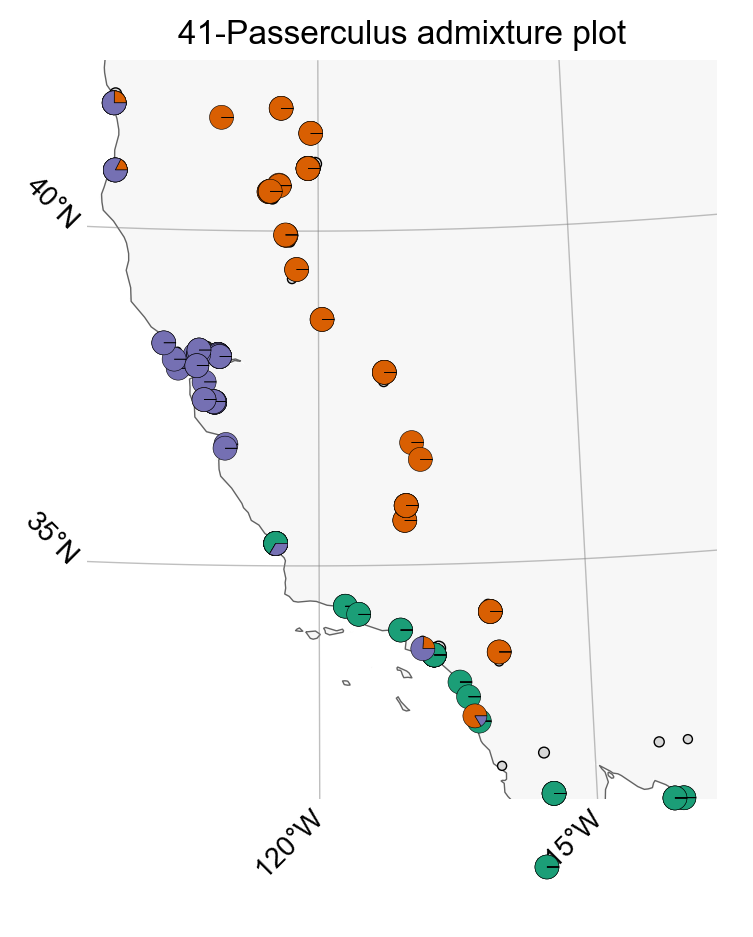

In [157]:
colors_k3 = ["#1b9e77", "#d95f02", "#7570b3"] 
Q_k3 = np.loadtxt("{}/{}.3.Q".format(filename,filename))
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=[[35,40],[-115,-120,-125]]); v.draw_obs_nodes(use_ids=False);# v.draw_edges(use_weights=False);  v.draw_edge_colorbar()
v.ax.set_title("{} admixture plot".format(filename))
radius = 0.3
for i in range(genotypes.shape[0]):
    projxy = project_coords(np.array([coord[i,:]]),v.proj)
    draw_admix_pie(Q_k3[i, :], projxy[0,0], projxy[0,1], colors_k3, radius=radius, ax=ax)
# for i in obj.perm_idx[:sp_graph.n_observed_nodes]:
#     draw_admix_pie(np.mean(Q_k3[sp_graph.nodes[i]['sample_idx'], :],axis=0).tolist(), v.grid[i, 0], v.grid[i, 1], colors_k3, radius=radius, ax=ax)

In [155]:
contour_dict = {}
for dest in np.unique(outliers_df['dest.']):
    contour_dict[dest] = obj.calc_contour(destid=int(dest), search_area='all', exclude_boundary=True)

Optimizing likelihood over 857 demes in the graph...
25%...50%...(752, 31)
(753, 31)
(777, 31)
(778, 31)
(802, 31)
75%...done!
Optimizing likelihood over 857 demes in the graph...
25%...50%...(777, 32)
(801, 32)
(802, 32)
(824, 32)
(825, 32)
75%...done!
Optimizing likelihood over 858 demes in the graph...
25%...50%...75%...done!
Optimizing likelihood over 858 demes in the graph...
25%...50%...75%...done!


/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Use

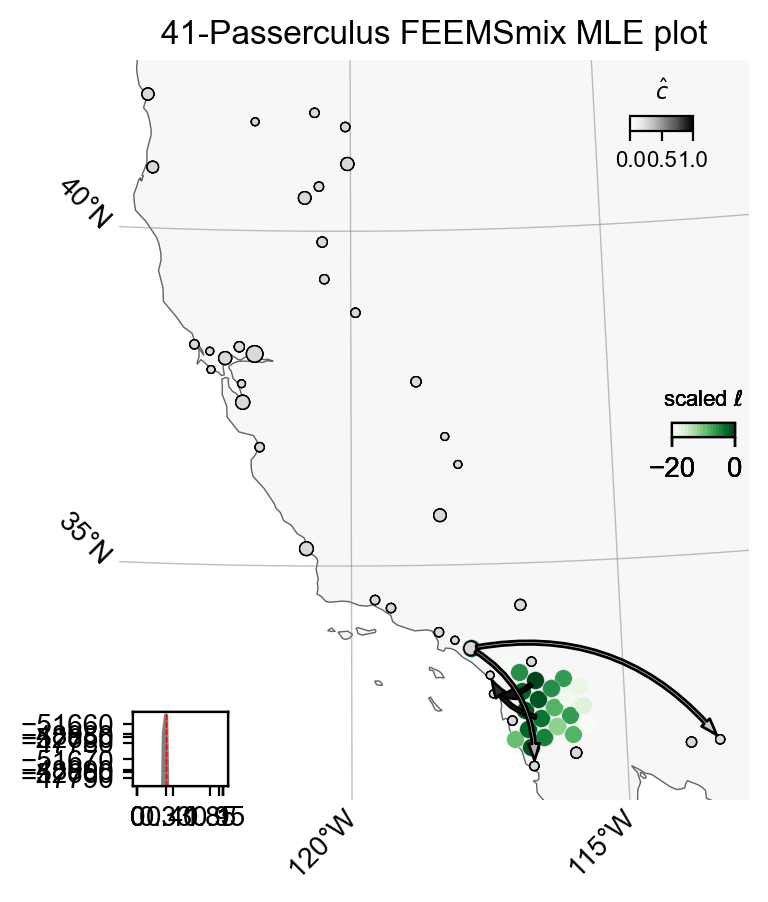

In [156]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=[[35,40],[-115,-120,-125]]); v.draw_obs_nodes(use_ids=False);# v.draw_edges(use_weights=False);  v.draw_edge_colorbar()
v.ax.set_title("{} FEEMSmix MLE plot".format(filename)); v.draw_c_colorbar()
# for i in obj.perm_idx[:sp_graph.n_observed_nodes]:
#     draw_admix_pie(np.mean(Q_k3[sp_graph.nodes[i]['sample_idx'], :],axis=0).tolist(), v.grid[i, 0], v.grid[i, 1], colors_k3, radius=radius, ax=ax)
for dest in list(contour_dict.keys()):
    v.draw_arrow([contour_dict[dest]['(source, dest.)'].iloc[np.argmax(contour_dict[dest]['scaled log-lik'])]],contour_dict[dest]['admix. prop.'].iloc[np.argmax(contour_dict[dest]['scaled log-lik'])])
    v.draw_ll_contour(contour_dict[dest], levels=[-20,0]); v.draw_obs_nodes(use_ids=False)

Optimizing likelihood over 995 demes in the graph...
25%...50%...75%...done!


/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivas

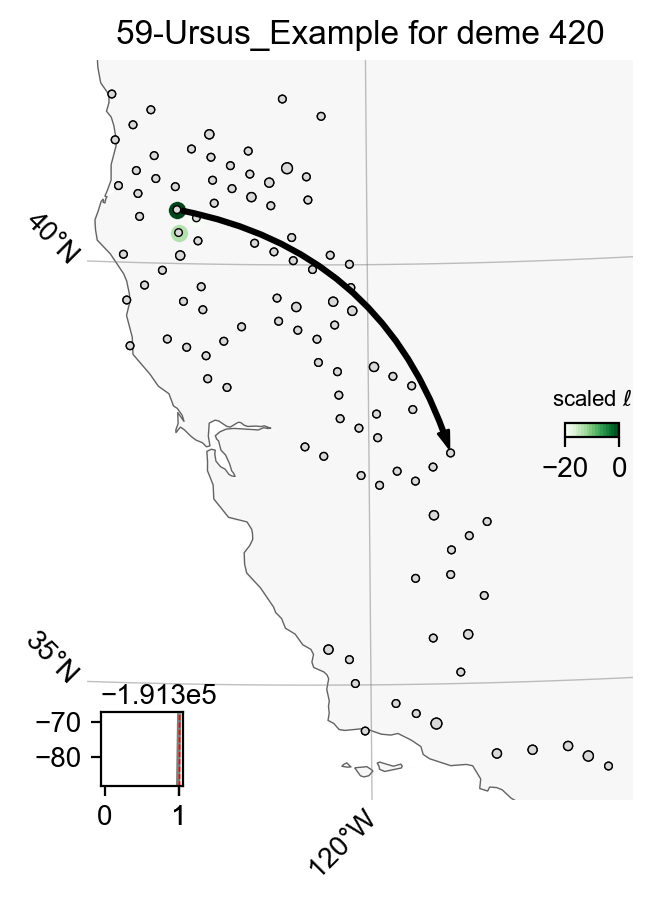

In [164]:
contour_df696 = obj.calc_contour(destid = 420, search_area='all', exclude_boundary=False)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, obj, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
v.draw_map(latlong=[[35,40],[-115,-120,-125]]); v.draw_obs_nodes(use_ids=False);# v.draw_edges(use_weights=False);  v.draw_edge_colorbar()
v.ax.set_title("{} for deme 420".format(filename)); #v.draw_c_colorbar()
v.draw_arrow([contour_df696['(source, dest.)'].iloc[np.argmax(contour_df696['scaled log-lik'])]],contour_df696['admix. prop.'].iloc[np.argmax(contour_df696['scaled log-lik'])])
v.draw_ll_contour(contour_df696, levels=[-20,0]); v.draw_obs_nodes(use_ids=False)